##                 MDP ITEMS COLLECTION 2022

In [ ]:
#import packages
#from pycaret.clustering import *
import pandas as pd
import pandas_gbq
import io
import datetime as dt
from functools import reduce
import requests
import time
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('/work/key.json')
bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)



### Get data from BigQuery

In [ ]:
#Call MDP data
mdp_data= pd.io.gbq.read_gbq('''
select
    distinct cast(a.item_id as int64) as ID,
    a.view_item_list_1d,
    view_item_list_7d,
    a.view_item_list_30d,
    a.view_item_1d,
    a.view_item_7d,
    a.view_item_30d,
    a.add_to_cart_1d,
    a.add_to_cart_7d,
    a.add_to_cart_30d,
    a.begin_checkout_1d,
    a.begin_checkout_7d,
    a.begin_checkout_30d,
    a.purchase_1d,
    a.purchase_7d,
    a.purchase_30d,
    a.qty_sold,
    a.nbre_commande,
    a.product_marge,
    a.order_recency,
    a.order_seniority,
    cast(a.stock as int64) as stock,
from `mdp-paris.dbt_pipeline_prod.con_product_segmentation` a
left join
    `mdp-paris.dbt_pipeline_prod.stg_presta_product_performance` b
    on a.item_id = b.product_id
where collection = 'Collection 2022'

''', project_id=credentials.project_id, dialect='standard', credentials = credentials )

In [ ]:
mdp_data

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,begin_checkout_30d,purchase_1d,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock
0,7563,2210,21532,71341,31,289,1623,0,3,13,...,27,0,1,5,47,46,19411.0,6,172,<NA>
1,7564,883,10210,28088,30,238,699,3,29,79,...,101,1,5,14,27,27,6183.0,1,170,248
2,7565,613,6655,18279,23,151,341,1,10,19,...,11,0,0,1,2,2,208.0,14,148,45
3,7566,574,6680,17316,14,121,265,1,16,31,...,18,0,1,3,9,4,416.0,2,84,60
4,7567,1214,13127,35223,45,377,1712,0,13,37,...,50,0,2,5,20,20,4760.0,2,171,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,8431,1026,9523,34023,69,534,2232,1,7,15,...,16,0,1,1,1,1,204.0,2,2,29
279,8433,1011,8751,31753,35,266,918,0,3,14,...,9,0,1,1,2,2,476.0,4,9,101
280,8437,546,4758,14579,27,216,674,1,12,17,...,10,1,2,2,2,2,476.0,1,4,49
281,8445,<NA>,0,0,<NA>,8,8,<NA>,0,0,...,0,<NA>,0,0,<NA>,<NA>,NaN,<NA>,<NA>,101


### Data processing

In [ ]:
#Data preprocessing
s= setup(mdp_data,session_id=123,ignore_features=['ID'],numeric_features=['add_to_cart_1d','begin_checkout_1d','purchase_1d','purchase_7d'], normalize=True)


,Description,Value
0,session_id,123
1,Original Data,"(241, 22)"
2,Missing Values,True
3,Numeric Features,21
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(241, 21)"
9,CPU Jobs,-1


In [ ]:
#generate analytical model
kmeans=create_model('kmeans',num_clusters=4)
print(kmeans)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2188,79.7326,1.468,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=123, tol=0.0001, verbose=0)


In [ ]:
#model assignment
kmean_results = assign_model(kmeans)
kmean_results.head()

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,purchase_1d,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock,Cluster
0,7563,2068,15669,65850,78,625,5215,0,1,44,...,0,1,4,42,42,17346.0,4,145,<NA>,Cluster 2
1,7564,691,4457,23470,37,118,393,1,1,7,...,0,0,0,9,9,2061.0,52,143,275,Cluster 1
2,7565,470,2851,15126,10,72,294,0,0,2,...,0,0,0,1,1,104.0,121,121,43,Cluster 1
3,7566,456,3004,16646,5,27,131,0,0,1,...,0,0,0,2,1,104.0,57,57,72,Cluster 1
4,7567,832,5234,27711,68,689,5137,1,4,33,...,0,0,3,15,15,3570.0,19,144,12,Cluster 1


### Model Vizualisation

In [ ]:
#PCA plot
plot_model(kmeans)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


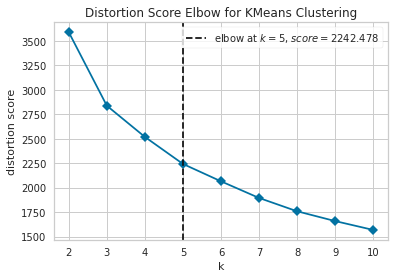

In [ ]:
#Elbow Plot
plot_model(kmeans, plot = 'elbow')

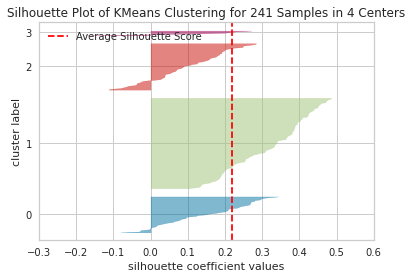

In [ ]:
#Silhouette Plot
plot_model(kmeans, plot = 'silhouette')

### Means of variables

In [ ]:
kmean_results.groupby('Cluster').mean()

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,begin_checkout_30d,purchase_1d,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock
Cluster,,,,,,,,,,,,,,,,,,,,,
Cluster 0,8006.836735,3623.122449,23420.0,99850.877551,129.714286,828.959184,3339.469388,3.0,15.571429,71.163265,...,70.693878,0.469388,2.163265,10.102041,23.857143,23.489796,5729.591837,3.795918,54.102041,25.244444
Cluster 1,7849.967213,971.04918,6138.97541,30779.688525,24.040984,150.122951,677.02459,0.459016,3.565574,18.483607,...,17.581967,0.040984,0.254098,1.836066,13.02459,12.721311,3227.262295,25.581967,119.639344,46.243697
Cluster 2,7851.507937,1291.365079,8624.047619,39331.904762,67.984127,490.730159,2090.031746,1.047619,9.634921,49.825397,...,51.777778,0.253968,1.603175,7.650794,42.333333,41.68254,9917.301587,4.746032,127.365079,34.754717
Cluster 3,8089.428571,3088.714286,19675.428571,79789.0,719.428571,4376.0,10261.428571,4.714286,46.142857,232.571429,...,252.857143,1.285714,6.571429,38.571429,102.142857,101.142857,25992.142857,1.714286,90.857143,26.2


### Prediction

In [ ]:
unseen_predictions = predict_model(kmeans, mdp_data)
unseen_predictions


,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,purchase_1d,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock,Cluster
0,7563,2068,15669,65850,78,625,5215,0,1,44,...,0,1,4,42,42,17346.0,4,145,<NA>,Cluster 2
1,7564,691,4457,23470,37,118,393,1,1,7,...,0,0,0,9,9,2061.0,52,143,275,Cluster 1
2,7565,470,2851,15126,10,72,294,0,0,2,...,0,0,0,1,1,104.0,121,121,43,Cluster 1
3,7566,456,3004,16646,5,27,131,0,0,1,...,0,0,0,2,1,104.0,57,57,72,Cluster 1
4,7567,832,5234,27711,68,689,5137,1,4,33,...,0,0,3,15,15,3570.0,19,144,12,Cluster 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8244,945,6793,36900,68,224,788,0,0,4,...,0,0,0,12,12,3456.0,49,170,46,Cluster 1
237,8246,1372,7722,37219,44,380,1248,1,14,55,...,0,2,7,25,25,6975.0,2,83,155,Cluster 2
238,8249,2183,15704,60915,146,1264,6563,2,10,262,...,0,3,54,103,102,39964.0,3,95,1,Cluster 3
239,8270,3731,26649,113383,256,1398,6077,4,9,55,...,2,3,9,45,43,12960.0,1,61,<NA>,Cluster 0


In [ ]:
_deepnote_run_altair(unseen_predictions, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":true},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"COUNT(*)","type":"quantitative","sort":null,"aggregate":"count","scale":{"type":"linear","zero":false}},"y":{"field":"Cluster","type":"nominal","sort":null,"scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
#naming of segments 
unseen_predictions['Cluster'].replace(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'],['Medium Hot','Cold','Hot Old','Top Hot'],inplace=True)

#rename cluster column
unseen_predictions.rename(columns={"Cluster": "Segments"},inplace=True)
unseen_predictions

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,purchase_1d,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock,Segments
0,7563,2068,15669,65850,78,625,5215,0,1,44,...,0,1,4,42,42,17346.0,4,145,<NA>,Hot Old
1,7564,691,4457,23470,37,118,393,1,1,7,...,0,0,0,9,9,2061.0,52,143,275,Cold
2,7565,470,2851,15126,10,72,294,0,0,2,...,0,0,0,1,1,104.0,121,121,43,Cold
3,7566,456,3004,16646,5,27,131,0,0,1,...,0,0,0,2,1,104.0,57,57,72,Cold
4,7567,832,5234,27711,68,689,5137,1,4,33,...,0,0,3,15,15,3570.0,19,144,12,Cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8244,945,6793,36900,68,224,788,0,0,4,...,0,0,0,12,12,3456.0,49,170,46,Cold
237,8246,1372,7722,37219,44,380,1248,1,14,55,...,0,2,7,25,25,6975.0,2,83,155,Hot Old
238,8249,2183,15704,60915,146,1264,6563,2,10,262,...,0,3,54,103,102,39964.0,3,95,1,Top Hot
239,8270,3731,26649,113383,256,1398,6077,4,9,55,...,2,3,9,45,43,12960.0,1,61,<NA>,Medium Hot


In [ ]:
_deepnote_run_altair(unseen_predictions, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":true},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"COUNT(*)","type":"quantitative","sort":null,"aggregate":"count","scale":{"type":"linear","zero":false}},"y":{"field":"Segments","type":"nominal","sort":null,"scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
#Load data that contains the item picture
base_image=pd.read_csv('base_image.csv',sep=',')
base_image

,ID,Title,Color,Product Type,Shippping,custom_label_0,Description,availability,Condition,Sale Price,Price,Brand,gtin,identifier_exists,link,image_link,URL de l'image 1,Neutre
0,6328,Pantalon Abell,Multicolor,Pantalon,0,Last Chance Winter,"Confectionné dans un mélange de matière noble,...",In Stock,New,127.5,255.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/pantalo...,https://media.mesdemoisellesparis.com/18969-fa...,https://media.mesdemoisellesparis.com/18968-fa...,neutre
1,6337,Manteau Arsine,Midnight,Manteau,0,Last Chance Winter,Veste stylée réalisée en mouton retourné synth...,In Stock,New,685.0,1370.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/manteau...,https://media.mesdemoisellesparis.com/19373-fa...,https://media.mesdemoisellesparis.com/19374-fa...,neutre
2,6372,Robe Begonia,Ecru/ocre,Robe,0,Last Chance Winter,"Cette robe mélodieuse et romantique, elle s'in...",In Stock,New,110.0,220.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/robe/63...,https://media.mesdemoisellesparis.com/20032-fa...,https://media.mesdemoisellesparis.com/18977-fa...,neutre
3,6378,Kimono Benson,Blue,Kimono,0,Last Chance Winter,"Ce long kimono en soie, emblème de la maison, ...",In Stock,New,102.5,205.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/kimono/...,https://media.mesdemoisellesparis.com/19375-fa...,https://media.mesdemoisellesparis.com/19376-fa...,neutre
4,6392,Combinaison Bradley,Blue,Combinaison,0,Last Chance Winter,"Féminine et éthérée, cette combinaison associe...",In Stock,New,127.5,255.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/combina...,https://media.mesdemoisellesparis.com/18923-fa...,https://media.mesdemoisellesparis.com/18925-fa...,neutre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,8244,Pull Kerwel,Black,Pull,0,Spring Summer 2022,"Façon poncho, facile à enfiler sur vos tenues ...",In Stock,New,345.0,345.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/pull/82...,https://media.mesdemoisellesparis.com/20022-fa...,https://media.mesdemoisellesparis.com/20018-fa...,neutre
628,8246,Escarpins Giennah,Black,Escarpins,0,Spring Summer 2022,"Avec cette paire de sandales, notre maison ins...",In Stock,New,335.0,335.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/escarpi...,https://media.mesdemoisellesparis.com/20801-fa...,https://media.mesdemoisellesparis.com/20800-fa...,neutre
629,8270,Robe Phale,Charcoal/Ecru,Robe,0,Spring Summer 2022,"Dans la famille des robes, osez ce modèle qui ...",In Stock,New,345.0,345.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/robe/82...,https://media.mesdemoisellesparis.com/21298-fa...,https://media.mesdemoisellesparis.com/21295-fa...,neutre
630,8281,Ensemble Meka,Terre De Sienne,Ensemble,0,Spring Summer 2022,Issu du charme de la lingerie féminine notre e...,In Stock,New,115.0,115.0,Mes Demoiselles,FB_GENERIC_TAXABLE,YES,https://www.mesdemoisellesparis.com/fr/ensembl...,https://media.mesdemoisellesparis.com/20675-fa...,https://media.mesdemoisellesparis.com/20674-fa...,neutre


In [ ]:
#join our table with the url image column
final=unseen_predictions.merge(base_image[['ID','URL de l\'image 1']],how='left',on='ID')
final

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,purchase_7d,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock,Segments,URL de l'image 1
0,7563,2068,15669,65850,78,625,5215,0,1,44,...,1,4,42,42,17346.0,4,145,<NA>,Hot Old,NaN
1,7564,691,4457,23470,37,118,393,1,1,7,...,0,0,9,9,2061.0,52,143,275,Cold,https://media.mesdemoisellesparis.com/20553-fa...
2,7565,470,2851,15126,10,72,294,0,0,2,...,0,0,1,1,104.0,121,121,43,Cold,https://media.mesdemoisellesparis.com/20588-fa...
3,7566,456,3004,16646,5,27,131,0,0,1,...,0,0,2,1,104.0,57,57,72,Cold,https://media.mesdemoisellesparis.com/20653-fa...
4,7567,832,5234,27711,68,689,5137,1,4,33,...,0,3,15,15,3570.0,19,144,12,Cold,https://media.mesdemoisellesparis.com/20552-fa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8244,945,6793,36900,68,224,788,0,0,4,...,0,0,12,12,3456.0,49,170,46,Cold,https://media.mesdemoisellesparis.com/20018-fa...
237,8246,1372,7722,37219,44,380,1248,1,14,55,...,2,7,25,25,6975.0,2,83,155,Hot Old,https://media.mesdemoisellesparis.com/20800-fa...
238,8249,2183,15704,60915,146,1264,6563,2,10,262,...,3,54,103,102,39964.0,3,95,1,Top Hot,NaN
239,8270,3731,26649,113383,256,1398,6077,4,9,55,...,3,9,45,43,12960.0,1,61,<NA>,Medium Hot,https://media.mesdemoisellesparis.com/21295-fa...


In [ ]:
#rename column "URL de l\'image 1"
final=final.rename(columns={"URL de l\'image 1": "image"})

In [ ]:
mdp_ref= pd.io.gbq.read_gbq('''
select
    distinct cast(a.item_id as int64) as ID,
    b.reference
from `mdp-paris.dbt_pipeline_prod.con_product_segmentation` a
left join
    `mdp-paris.dbt_pipeline_prod.stg_presta_product_performance` b
    on a.item_id = b.product_id
where collection = 'Collection 2022'

''', project_id=credentials.project_id, dialect='standard', credentials = credentials )

In [ ]:
#Display dataframe
final= final.merge(mdp_ref,how='left',on='ID')

In [ ]:
final

,ID,view_item_list_1d,view_item_list_7d,view_item_list_30d,view_item_1d,view_item_7d,view_item_30d,add_to_cart_1d,add_to_cart_7d,add_to_cart_30d,...,purchase_30d,qty_sold,nbre_commande,product_marge,order_recency,order_seniority,stock,Segments,image,reference
0,7563,2068,15669,65850,78,625,5215,0,1,44,...,4,42,42,17346.0,4,145,<NA>,Hot Old,NaN,22S_MONATELLA-TERRE DE SIENNE
1,7564,691,4457,23470,37,118,393,1,1,7,...,0,9,9,2061.0,52,143,275,Cold,https://media.mesdemoisellesparis.com/20553-fa...,22S_MARA-TERRE DE SIENNE
2,7565,470,2851,15126,10,72,294,0,0,2,...,0,1,1,104.0,121,121,43,Cold,https://media.mesdemoisellesparis.com/20588-fa...,22S_MIA-TERRE DE SIENNE
3,7566,456,3004,16646,5,27,131,0,0,1,...,0,2,1,104.0,57,57,72,Cold,https://media.mesdemoisellesparis.com/20653-fa...,22S_MENEO-TERRE DE SIENNE
4,7567,832,5234,27711,68,689,5137,1,4,33,...,3,15,15,3570.0,19,144,12,Cold,https://media.mesdemoisellesparis.com/20552-fa...,22S_MIANNI-TERRE DE SIENNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8244,945,6793,36900,68,224,788,0,0,4,...,0,12,12,3456.0,49,170,46,Cold,https://media.mesdemoisellesparis.com/20018-fa...,22S_KERWEL-BLACK
237,8246,1372,7722,37219,44,380,1248,1,14,55,...,7,25,25,6975.0,2,83,155,Hot Old,https://media.mesdemoisellesparis.com/20800-fa...,22S_GIENNAH-BLACK
238,8249,2183,15704,60915,146,1264,6563,2,10,262,...,54,103,102,39964.0,3,95,1,Top Hot,NaN,22S_PERKINS-SUNSET COMBO
239,8270,3731,26649,113383,256,1398,6077,4,9,55,...,9,45,43,12960.0,1,61,<NA>,Medium Hot,https://media.mesdemoisellesparis.com/21295-fa...,22S_PHALE-CHARCOAL/ECRU


In [ ]:
import joblib
joblib.dump(kmeans, 'kmeans.joblib')

['kmeans.joblib']

### push data into BigQuery

In [ ]:
# Push Data to BigQuery
import pandas_gbq
table_id= 'reportings.hot_cold_product'
final.to_gbq(table_id,if_exists='replace', credentials=credentials)

100%|██████████| 1/1 [00:00<00:00, 318.04it/s]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=08a4d91e-cdf8-4f34-a2e4-ebb5990d58fe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>